# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import trange
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
random_state = 12345
import warnings

In [200]:
warnings.filterwarnings('ignore')

In [201]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

Поскольку в работе имеем три дата-сета, для удобства объеденим их в массив(список датафреймов) и будем работать с ним.

In [202]:
data_list = [data_0, data_1, data_2]

In [203]:
for data in data_list:
    print(data.head())

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647
      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305
      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746


Признаки f оставим, признак id  нужно будет убрать.

In [204]:
for data in data_list:
    print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column  

In [205]:
for data in data_list:
    print(data.duplicated().sum())

0
0
0


Пропусков и дупликатов нет, данные чистые.

In [206]:
for data in data_list:
    print(data.describe())

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%       

В целом притзнаки как будто распределены нормально, но как будто бы будет хорошо их нормализовать.

In [207]:
for data in data_list:
    print(data.corr())

               f0        f1        f2   product
f0       1.000000 -0.440723 -0.003153  0.143536
f1      -0.440723  1.000000  0.001724 -0.192356
f2      -0.003153  0.001724  1.000000  0.483663
product  0.143536 -0.192356  0.483663  1.000000
               f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000
               f0        f1        f2   product
f0       1.000000  0.000528 -0.000448 -0.001987
f1       0.000528  1.000000  0.000779 -0.001012
f2      -0.000448  0.000779  1.000000  0.445871
product -0.001987 -0.001012  0.445871  1.000000


Во втором месторождении наблюдается сильная зависимость от признака f2.

In [208]:
for i in range(len(data_list)):
    data_list[i] = data_list[i].drop(columns=['id'], axis=0)

Убрали признак id.

## Обучение и проверка модели

Для удобства напишем функцию разделения на тренировачные и валидационные выборки.

In [209]:
def split(data): 
    train, valid = train_test_split(data, test_size=0.25, random_state=random_state)
    features_train = train.drop(columns=['product'], axis=0)
    target_train = train['product']
    features_valid = valid.drop(columns=['product'], axis=0)
    target_valid= valid['product']
    return features_train, target_train, features_valid , target_valid

In [210]:
features_train_0, target_train_0, features_valid_0, target_valid_0 = split(data_list[0])
features_train_1, target_train_1, features_valid_1, target_valid_1 = split(data_list[1])
features_train_2, target_train_2, features_valid_2, target_valid_2 = split(data_list[2])

Как и планировалось нормализуем признаки.

In [211]:
scaler = StandardScaler()
scaler.fit(features_train_0)
features_train_0 = scaler.transform(features_train_0)
features_valid_0 = scaler.transform(features_valid_0)

scaler.fit(features_train_1)
features_train_1 = scaler.transform(features_train_1)
features_valid_1 = scaler.transform(features_valid_1)

scaler.fit(features_train_2)
features_train_2 = scaler.transform(features_train_2)
features_valid_2 = scaler.transform(features_valid_2)

Можем приступать к обучению моделей

In [212]:
model = LinearRegression() 
def results (features_train, target_train, features_valid, target_valid):  
    model.fit(features_train, target_train)
    predict = pd.Series(model.predict(features_valid), target_valid.index)
    mse = mean_squared_error(predict, target_valid)
    predict_mean = predict.mean()
    rmse = mse ** 0.5
    print ("Предсказанный средний запас:", predict_mean)
    print ("RMSE:", rmse)
    return predict

In [213]:
predict_0 = results(features_train_0, target_train_0, features_valid_0, target_valid_0)

Предсказанный средний запас: 92.59256778438035
RMSE: 37.5794217150813


In [214]:
predict_1 = results(features_train_1, target_train_1, features_valid_1, target_valid_1)

Предсказанный средний запас: 68.728546895446
RMSE: 0.893099286775617


In [215]:
predict_2 = results(features_train_2, target_train_2, features_valid_2, target_valid_2)

Предсказанный средний запас: 94.96504596800489
RMSE: 40.02970873393434


Ошибка в 0 и 2 регионе очень высока относительно результата, а вот с 1 регионом работать будет приятно, скорее всего это из-за высокой корреляции с признаком f2.

In [216]:
predict_0

71751     95.894952
80493     77.572583
2655      77.892640
53233     90.175134
91141     70.510088
            ...    
12581    103.037104
18456     85.403255
73035     61.509833
63834    118.180397
43558    118.169392
Length: 25000, dtype: float64

In [217]:
predict_1

71751     82.663314
80493     54.431786
2655      29.748760
53233     53.552133
91141      1.243856
            ...    
12581    136.869211
18456    110.693465
73035    137.879341
63834     83.761966
43558     53.958466
Length: 25000, dtype: float64

In [218]:
target_valid_1

71751     80.859783
80493     53.906522
2655      30.132364
53233     53.906522
91141      0.000000
            ...    
12581    137.945408
18456    110.992147
73035    137.945408
63834     84.038886
43558     53.906522
Name: product, Length: 25000, dtype: float64

## Подготовка к расчёту прибыли

Сохраним все переменные необходимые для расчета

In [219]:
wells = 200
budget = 10000000000
price_barrel = 450000
risk = 0.025
well_cost = budget/wells
min_stock = well_cost/price_barrel
print (well_cost,min_stock)

50000000.0 111.11111111111111


Показатель средних запасов относительно необходимого оставляет желать лучшего, 0 и 1 регион дают надежду, но там большая ошибка.

## Расчёт прибыли и рисков 

Напишем функцию расчета прибыли 

In [220]:
def revenue(target, probabilities, count): 
    probs_sort = probabilities.sort_values(ascending=False)
    selected = target[probs_sort.index][:count]
    return selected.sum() * price_barrel - budget

Средняя выручка: 425938526.91059244
95% доверительный интервал: -102090094.83793654 : 947976353.3583689
Риск убытков: 0.06


Text(0.5, 1.0, 'Регион 0')

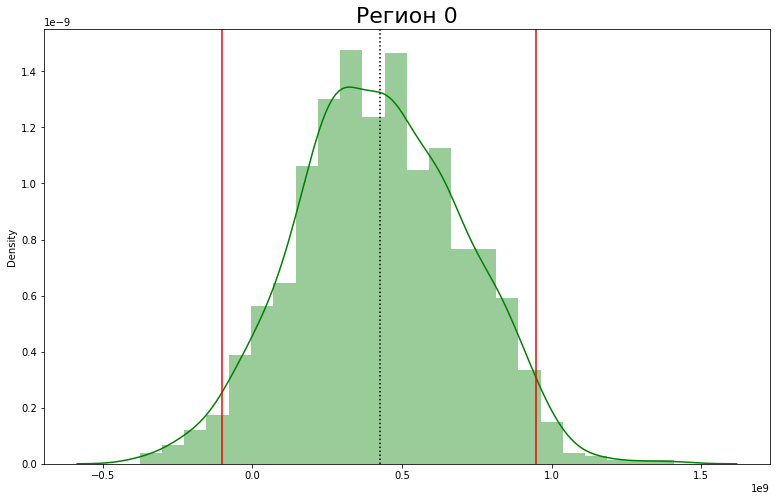

In [224]:
values = []
counter = 0
state = np.random.RandomState(random_state)
for i in range(1000):
    target_subsample = target_valid_0.sample(n = 500, replace=True, random_state=state)
    probs_subsample = predict_0.loc[target_subsample.index] 
    reven = revenue(target_subsample, probs_subsample, wells)
    values.append(reven)
    
values = pd.Series(values)
lower = values.quantile(risk)
upper = values.quantile(0.975)
mean =  values.mean()
print("Средняя выручка:",mean)
print ('95% доверительный интервал:',lower,":", upper)
print('Риск убытков:',values[values < 0].count() / len(values))

plt.figure(figsize=(13,8))
sns.distplot(values, color = 'green')
plt.axvline(lower, color='r')
plt.axvline(mean, color='black', linestyle=':')
plt.axvline(upper, color='r')
plt.title('Регион 0', fontsize=22)

Средняя выручка: 515222773.4432899
95% доверительный интервал: 68873225.37050176 : 931547591.2570494
Риск убытков: 0.01


Text(0.5, 1.0, 'Регион 1')

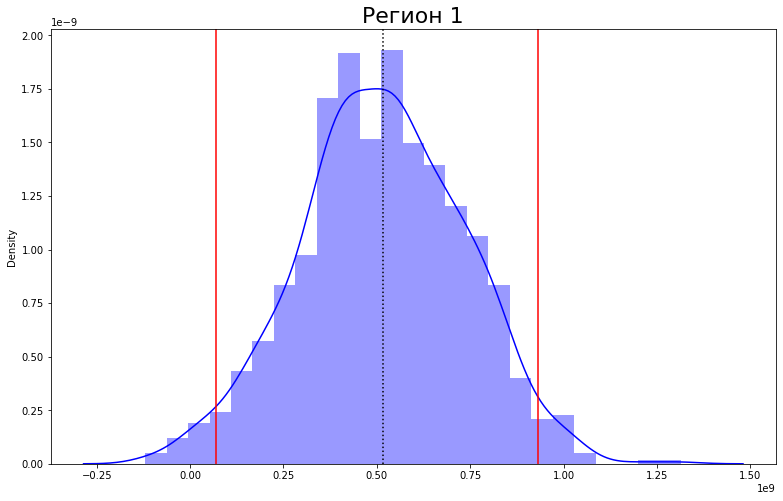

In [225]:
values = []
counter = 0
state = np.random.RandomState(random_state)
for i in range(1000):
    target_subsample = target_valid_1.sample(n = 500, replace=True, random_state=state)
    probs_subsample = predict_1.loc[target_subsample.index] 
    reven = revenue(target_subsample, probs_subsample, wells)
    values.append(reven)
    
values = pd.Series(values)
lower = values.quantile(risk)
upper = values.quantile(0.975)
mean =  values.mean()
print("Средняя выручка:",mean)
print ('95% доверительный интервал:',lower,":", upper)
print('Риск убытков:',values[values < 0].count() / len(values))

plt.figure(figsize=(13,8))
sns.distplot(values, color = 'blue')
plt.axvline(lower, color='r')
plt.axvline(mean, color='black', linestyle=':')
plt.axvline(upper, color='r')
plt.title('Регион 1', fontsize=22)

Средняя выручка: 435008362.7827556
95% доверительный интервал: -128880547.32978901 : 969706954.1802661
Риск убытков: 0.064


Text(0.5, 1.0, 'Регион 2')

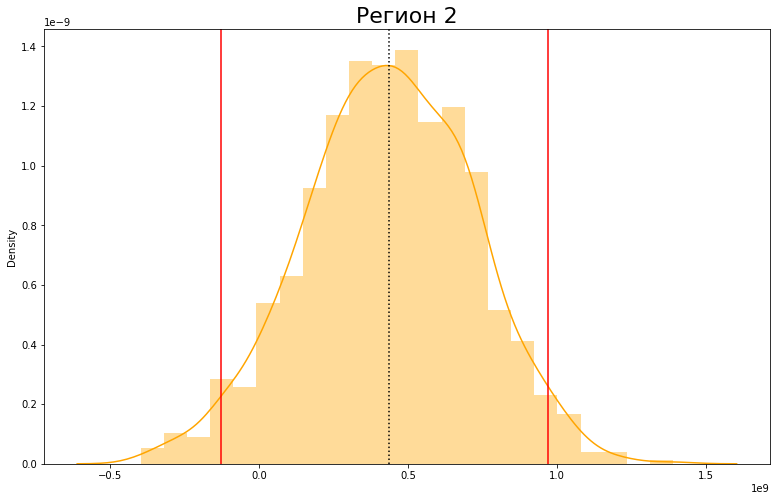

In [226]:
values = []
counter = 0
state = np.random.RandomState(random_state)
for i in range(1000):
    target_subsample = target_valid_2.sample(n = 500, replace=True, random_state=state)
    probs_subsample = predict_2.loc[target_subsample.index] 
    reven = revenue(target_subsample, probs_subsample, wells)
    values.append(reven)
    
values = pd.Series(values)
lower = values.quantile(risk)
upper = values.quantile(0.975)
mean =  values.mean()
print("Средняя выручка:",mean)
print ('95% доверительный интервал:',lower,":", upper)
print('Риск убытков:',values[values < 0].count() / len(values))

plt.figure(figsize=(13,8))
sns.distplot(values, color = 'orange')
plt.axvline(lower, color='r')
plt.axvline(mean, color='black', linestyle=':')
plt.axvline(upper, color='r')
plt.title('Регион 2', fontsize=22)

**Вывод: выбираем регион 1**
* RMSE  позволяет надеяться на точность
* Самый низкий риск убытков, и единственный вписывается в риск заданный заказчиком
